# Lesson 4: Under the Hood: Training a Digit Classifier

**28-09-2020**

This notebook will go over *some* of the practical material discussed in [lesson 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) of the fastai 2020 course, namely, some different ways of training a digit classifier using the MNIST data set. The lesson 4 video is an extension on the lesson 3 video. There is a lot to cover...

In the last notebook we looked at some simple examples of using SGD to optimise a model. In this notebook we will apply the concepts to the MNIST problem from scratch then leter, we will refactor the code using PyTorch and fastai modules.

In [1]:
# imports and things we need from previous notebooks

from fastai.vision.all import *

# data 
path = untar_data(URLs.MNIST_SAMPLE)

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [2]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

## MNIST Loss function

Our X values will be pixels, we need to reshape the data using `view`. We want to concatenate our x's into a single tensor, then change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). Why? Because this example is meant to be simplified. 

`view` will return a new tensor with the same data as the original tensor but with a different shape that we define.

In [3]:
# concat 3s and 7s, then reshape into a matrix
# so that each row is 1 image, with all rows and columns in a single vector
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

# label the data
# 3 == 1
# 7 == 0
# we need this to be a matrix
# unsqueeze will do this for us
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

# check the shape
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [4]:
# in PyTorch we need data to be in a tuple for each row
# zip will help us with this
dset = list(zip(train_x,train_y))

# take a look at the first thing
x,y = dset[0]

x.shape, y

(torch.Size([784]), tensor([1]))

`(torch.Size([784]), tensor([1]))` this matches what we would expect

In [5]:
# repeat for validation
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we have training and validation data sets

**1. Randomly initialise weights for each pixel**
- use `torch.randn` to create tensor of randomly initialised weights

In [8]:
def init_params(size, var=1.0): 
    return (torch.randn(size)*var).requires_grad_()

In [9]:
weights = init_params((28*28,1))

weights.shape

torch.Size([784, 1])

We need to add a bias term because just using `weights*pixels` will not be flexible enough. Our function will always be equal to zero when the pixels are equal to zero.  

In [10]:
bias = init_params(1)

`y = w*x+b` is the formula for a line, where `w` are the weights, `b` is the bias. In neural network jargon, the weights and bias will be our *parameters*. 

This linear equation is one of the two fundamental equations of any neural network. The other is an *activation* function that we will see shortly.

Let's use this to calculate a prediction for one image... `weights.T` will transpose the weights, this is done to make sure the rows and columns match up for our multiplication

In [12]:
(train_x[0]*weights.T).sum() + bias

tensor([13.3326], grad_fn=<AddBackward0>)

Now we need to do this for *all* images. A for loop will be too slow. In PyTorch we can perform matrix multiplication using the @ operator OR by using `torch.matmul()`.

In [13]:
# define a linear function that will 
# multiple the input by weights then add a bias term

def linear1(xb): return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[13.3326],
        [ 9.1011],
        [ 9.4999],
        ...,
        [-1.0068],
        [15.9130],
        [12.6228]], grad_fn=<AddBackward0>)

Notice the result are the same as we just saw above. We can confirm our function is working and can also see that the operation is performed for every image in `train_x`

**checking accuracy**
- if a prediction is above the threshold, ie if > 0 then it is a 3, less than 0, 7.
- so we check if a prediction is greater than our threshold of 0, then check these against the validation set.
- this will return true when a row is correctly predicted
- we can convert these to floats using `.float()` then take their mean to check overall accuracy of our randomly initialised model

In [15]:
threshold = 0.0
accuracy = (preds > threshold).float() == train_y
accuracy

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [False]])

In [16]:
accuracy.float().mean().item()

0.484188437461853

Let's change one of the weights by a small amount to see how accuracy is affected.

In [17]:
weights[0]+= 1.0001 # increase the weigh a little
preds = linear1(train_x)
accuracy2 = ((preds > threshold).float() == train_y).float().mean().item()
accuracy2

0.484188437461853

This is exactly the same as before. We have a problem, when we calculate the change, our gradient is now 0, this is because if we change a single pixel by a very small amount we might not change an actual prediction.

So because our gradient is 0, our step will be 0 which means our prediction will be unchanged. 

So our accuracy loss function is not very good. A small change in our weights does not result in a small change in accuracy, so we will have zero gradients.

We need a new function that won't have a zero gradient, it needs to be more sensitive to small changes, so that a slightly better prediction needs to have a slightly better loss.

In other words, then the predictions are close to the targets the loss needs to be small, when they are far away, it needs to be big.

So let's create a new function to address this issue.

In [18]:
# MNIST loss

def mnist_loss(preds, targets):
    return torch.where(targets==1., 1.-preds, preds).mean()

In [19]:
# test case

t = torch.tensor([1,0,1])         # targets
p = torch.tensor([0.9, 0.4, 0.2]) # predictions


# this is the same as mnist_loss but before the mean
torch.where(t==1, 1-p, p)

tensor([0.1000, 0.4000, 0.8000])

`torch.where` is like list comprehension for tensors.

This function returns a lower loss when predictions are more accurate and a higher loss when they are not.

But for this to work, we need our predictions to be between 0 and 1, otherwise things do not work.

In [20]:
p2 = torch.tensor([1.2, -1, 0])   # predictions outside 0, 1 range

torch.where(t==1, 1-p2, p2)

tensor([-0.2000, -1.0000,  1.0000])

### The Sigmoid function

- This function will constrain our numbers between 0 and 1.
- It squashes any input in the range (-inf, inf) to some value in the range (0, 1)

In [21]:
def sigmoid(x) : return 1 / (1 + torch.exp(-x))

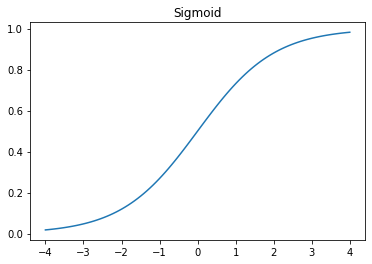

In [31]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [22]:
# MNIST loss with sigmoid

def mnist_loss(predictions, targets):
    preds = predictions.sigmoid()
    return torch.where(targets==1., 1.-preds, preds).mean()

## SGD and Mini-batches

By batching images and running computations over them is a way to compromise between speed and computational efficiency. 

The size of the batch will impact your accuracy and estimates as well as the speed at which you are able to run computations. The batch size is something to be considered during training.

The `DataLoader` class in pytorch helps with batching. It returns an iterator which we can loop through.

In [23]:
coll = range(15)

dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 4, 12,  5,  6,  3]),
 tensor([10,  9,  2,  0, 14]),
 tensor([ 7, 13,  8, 11,  1])]

### Putting it together

In [24]:
# re-initialise weights and params
weights = init_params((28*28,1))
bias = init_params(1)

In [25]:
# create a data loader
dl = DataLoader(dset, batch_size=256)

# grab the first x and y
xb, yb = first(dl)

# check the shape
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [26]:
# repeat for validation set
valid_dl = DataLoader(valid_dset, batch_size=256)

In [27]:
# grab a mini batch to test on
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [28]:
# make some predictions
preds = linear1(batch)
preds

tensor([[-1.1306],
        [-3.9293],
        [-0.6736],
        [-6.9805]], grad_fn=<AddBackward0>)

In [29]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.8495, grad_fn=<MeanBackward0>)

In [30]:
# calculate gradients
loss.backward()

weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0153), tensor([-0.1070]))

In [31]:
# take those 3 steps and put it in a function

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [32]:
# test it

calc_grad(batch, train_y[:4], linear1)

weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0306), tensor([-0.2140]))

In [33]:
# zero the gradients
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

The last step is to work out how to update the weights and bias based on the gradient and learning rate. 

`train_epoch` loops through the data loader, grab x batch and y batch, calculate the gradient, make a prediction and calculate the loss. Go through each parameter (weights and bias) and for each update with gradient * lr, then zero these in prep for the next loop. 

`p.data` is used because PyTorch keeps track of all operations so it can calculate the gradients, but we do not want the gradients to be calculated on the gradient descent step. 

In [37]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model) 
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()        

`batch_accuracy` is similar to the previous loss function, but since we use a sigmoid, which constrains our preds between 0 and 1, we need to check whether preds > 0.5.  

In [38]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb # check predictions against target
    return correct.float().mean()

In [39]:
batch_accuracy(linear1(train_x[:4]), train_y[:4])

tensor(0.)

In [42]:
# check accuracy for every batch in the validation set
# stack converts the list of items into tensor

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [41]:
validate_epoch(linear1)

0.407

This is a starting point, let's train for one epoch and see if accuracy improves.

as a reminder, the linear1 function was... 
- `def linear1(xb): return xb@weights + bias`

In [43]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6932

In [44]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8242 0.9042 0.9355 0.9501 0.9555 0.9614 0.9638 0.9677 0.9736 0.9751 0.9751 0.976 0.977 0.9775 0.9775 0.978 0.9785 0.979 0.9795 0.979 

Accuracy has indeed improved! We have built an SGD optimizer that has reached about 97% accuracy.

### Refactor and clean up

- create an optimiser 
- use PyTorch modules and functions where available
    - like `nn.Linear`
    - which "Applies a linear transformation to the incoming data: $y = xA^T + b$"

In [45]:
nn.Linear?

In [66]:
# remove our linear function
# in place for torch module

# creates a matrix of size 28*28
# with bias of 1

linear_model = nn.Linear(28*28,1)

In [67]:
# check model params

w,b = linear_model.parameters()

w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Create a basic optimiser

- pass in params to optimise and lr
- store these away
- step though each param (weights and bias) and for each, update with gradient * lr
- zero the gradients in prep for the next step

In [68]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

In [69]:
# create an optimiser by passing in parameters from model
opt = BasicOptim(linear_model.parameters(), lr)

In [70]:
# simplify the training loop
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [71]:
validate_epoch(linear_model)

0.5075

Now create a function `train_model` that will call `train_epoch` on our model for the specified number of epochs

In [72]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [73]:
train_model(linear_model, 20)

0.4932 0.7876 0.852 0.916 0.9345 0.9497 0.957 0.9638 0.9658 0.9677 0.9697 0.9721 0.9731 0.9751 0.9755 0.9765 0.9775 0.9775 0.978 0.9785 

The results are very similar to what we have seen before.

Fastai provides `SGD` that we can use instead of writing our own, again the results are very similar.

In [74]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.9091 0.8056 0.9043 0.9316 0.9443 0.9546 0.9619 0.9648 0.9668 0.9692 0.9707 0.9731 0.9746 0.976 0.976 0.9775 0.9775 0.9785 0.979 

Let's refactor some more, using some fastai classes. The `Learner` implements everything we have implemented manually.

In [75]:
# Previously we used DataLoader not DataLoaders

dls = DataLoaders(dl, valid_dl)

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(10)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.480832,0.461122,0.843474,00:00
1,0.466804,0.441299,0.908734,00:00
2,0.450758,0.422136,0.934249,00:00
3,0.433590,0.403750,0.943572,00:00
4,0.416052,0.386223,0.949460,00:00
5,0.398675,0.369610,0.952404,00:00
6,0.381799,0.353943,0.956820,00:00
7,0.365630,0.339228,0.957311,00:00
8,0.350289,0.325455,0.959764,00:00
9,0.335835,0.312599,0.960255,00:00


The results again are very similar, but with some additional functionality (like printing out results in a pretty table!

### Non-Linearity

To create a simple neural net, using a linear function like we did before is not enough. We need to add in a non-linearity between two linear functions. 

This is the basic definition for a neural net..

The *universal approximation theorem* says, that given any arbitrarily complex continuous function, we can approximate it with a neural network. I found [this](https://www.youtube.com/watch?v=Ijqkc7OLenI&ab_channel=MichaelNielsen) useful for visualising how this works. This is what we are trying to do.

In our `basic_net`, each line represents a *layer* in our network, the first and 3rd layers are known as *linear layers* the second, as a *nonlinearity* or an *activation.*

`res.max(tensor(0.0))` takes the result of our linear function and sets any negative value to 0.0 while maintaining any positive values.

In [83]:
def basic_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

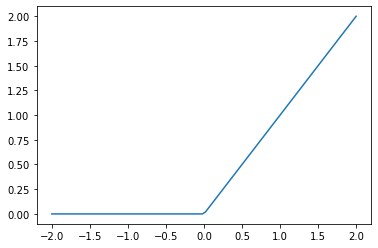

In [86]:
plot_function(F.relu)

Like we have seen previously..
- `w1` and `w2` are weight tensors
- `b1` and `b2` are bias tensors

we can initialise these the same as we have done previously..

`w1` has 30 output activations, so in order for `w2` to match it require 30 input activations. 

In [85]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

We can simplify further using PyTorch... 

What we did in `basic_net` was called function composition, where we passed the results of one function into another function and then into another function. This is what neural nets are doing with linear layers and activation functions. `nn.Sequential()` will do this for us...

In [87]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30), # 28*28 in, 30 out
    nn.ReLU(),
    nn.Linear(30,1)       # 30 in 1 out
)

In [88]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.301185,0.414520,0.506379,00:00
1,0.142869,0.223012,0.814033,00:00
2,0.079959,0.114103,0.916094,00:00
3,0.053115,0.077652,0.939156,00:00
4,0.040578,0.060868,0.953876,00:00
5,0.034118,0.051373,0.963690,00:00
6,0.030368,0.045362,0.965653,00:00
7,0.027905,0.041246,0.965162,00:00
8,0.026117,0.038246,0.968597,00:00
9,0.024726,0.035950,0.969087,00:00


In [94]:
# this is what our model now looks like
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

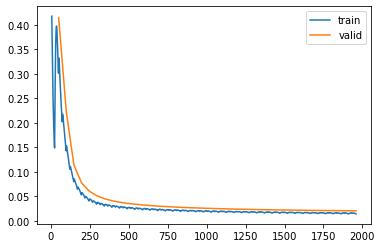

In [90]:
# plot the loss
learn.recorder.plot_loss()

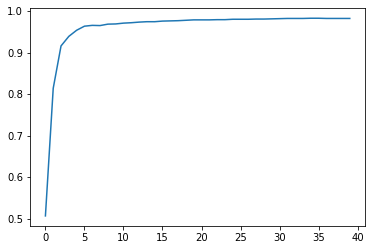

In [92]:
# learn.recorder.values hold the table values above
# lets plot the accuracy

plt.plot(L(learn.recorder.values).itemgot(2));

### Looking inside...

<AxesSubplot:>

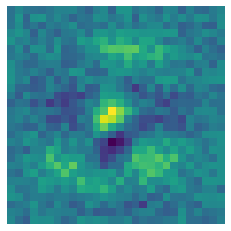

In [107]:
# let's visualise some of the parameters

# 1. grab your model
m = learn.model # (0): Linear(in_features=784, out_features=30, bias=True)

# 2. look inside and grab the weights and biases
w,b = m[0]. parameters()

# 3. grab first (or any) row, reshape, and plot
show_image(w[0].view(28,28), figsize=(4,4))

### fastai in full

In [1]:
from fastai.vision.all import *
from pathlib import Path

In [9]:
path = Path.cwd()/'datasets/fastai/mnist_sample'

In [10]:
dls = ImageDataLoaders.from_folder(path)

learn = cnn_learner(dls, resnet18, pretrained=False,
                   loss_func=F.cross_entropy, metrics=accuracy)

learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.086805,0.025215,0.994603,00:11


### Summary

We have gone over creating and training a neural network from scratch using the simple example of a digit classifier. The key idea for the last few notebooks was to start with planning out the problem and identifying a way to solve it using a simple common sense solution - the pixel similarity model. 

This proved successful but it was not really robust beyond the straightforward example we chose - identifying 3s and 7s. We then implemented a more complex solution that could be applied to more complicated problems. 

After each step or concept had been implemented manually, we refactored the code to use convenient PyTorch functions and modules, eventually ending up with using fastai's implementation which abstracts away from all of the underlying heavy lifting. This is done for convenience and in my own opinion, to help lower the entry barrier into deep learning. 

Ultimately I believe it is fundamentally important to understand the concepts and implementation if your goal (and this is my goal) is to implement deep learning solutions to solve business problems within your industry.